# PROJECT: Course Optimization for Data Science
## Optimization strategies for anomaly detection
## with One class Support Vector Machines (OCSVM)

Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- derive the dual for the one-class SVM model
- implement a one-class SVM using a blackbox convex toolbox (cvxopt in Python)
- implement your own solvers with: Proximal gradient, Coordinate Descent, Quasi-Newton
- Present a clear benchmark of the different strategies on small and medium scale datasets


## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 7th of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "robert"
ln1 = "gower"
fn2 = "alexandre"
ln2 = "gramfort"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_gower_robert_and_gramfort_alexandre.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='oceans16',context='notebook')

## Important:

For Part 0 to Part 2 of the project you will need a working install of `cvxopt`.
You may struggle a bit to set it up.
The simplest way of getting it is by typing 

`conda install cvxopt`

or

`pip install cvxopt`

if you have `conda` or `pip` installed on your laptop.
If you **struggle too much please
contact us**.

## Part 0: One-class SVM

The original formulation of the One-Class SVM introduced by Schölkopf [1] is given by

$$
    (\mathcal{P}): \left\{
	\begin{align}
	\min_{w, \rho, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq \rho - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{align}
    \right.
$$

where $\nu \in (0, 1]$ is a user-specified parameter controlling the proportion of outliers and the proportion of support vectors.

Getting rid of the slack variables $\xi_i, 1 \leq i \leq n$ one can also obtain the following equivalent optimization problem

$$
	\min_{w, \rho} \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \max(0, \rho - \langle w, x_i \rangle) \, .
$$

The idea is that the lower is $\langle w, x_i \rangle$ is the more $x_i$ is an anomaly and if $\langle w, x_i \rangle \geq \rho$ then the model predicts the sample is normal. $\langle w, x_i \rangle$ corresponds to the decision function and $\textrm{sign}(\langle w, x_i \rangle - \rho)$ as the prediction (1 means normal sample).

[1] Schölkopf et al. Estimating the support of a high-dimensional distribution. Neural Computation. 2001

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that the problem $(\mathcal{P})$ is convex.</li>
    </ul>
</div>

Let us call $f(w,\rho,\xi) = \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n \xi_i  $, f is obvously convex in w (the hessian is just the identity), and linear in $\rho$ and $\xi$. All the constraints are linear, thus the problem is convex 

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>
      By looking at the saddle points of the Lagrangian $\mathcal{L}(w, \rho, \mu)$ of $\mathcal{P}$, $\mu \in \mathbb{R}_+^n$, show that the dual problem $(\mathcal{D})$ can be written as:
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

with

$$
 G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix}
$$

and $1_n = (1, \dots, 1) \in \mathbb{R}^n$.
    </li>
    </ul>
</div>

We will **assume here qualification of the contraints** and that **strong duality holds**.

**Remark:** The problem $(\mathcal{D})$ is a *quadratic program* (QP) for which their exist off-the-shelf techniques. See below.

The problem $(\mathcal{P})$ can be rewritten in two sub-problems (we just need to find the better solution between both): 
$$ (\mathcal{P_1})\left\{
    \begin{array}{ll}
    \min_{w,\rho} &\frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n (\rho - \langle w, x_i \rangle) \, 
    \\
    \langle w,x_i \rangle - \rho\leq 0 
    \end{array}
    \right.
    $$
And 
$$(\mathcal{P_2})\left\{
    \begin{array}{ll}
    \min_{w,\rho} \frac{1}{2}\Vert w \Vert^2 - \rho  
    \\
    \rho - \langle w,x_i \rangle   \leq 0 
    \end{array}
    \right.
    $$
    


Let us consider the problem $(\mathcal{P_1})$: 

For this problem we can write the Lagrangian, let us define : $\lambda \in \mathbb{R}^n_+$ 
$$\mathcal{L}(w,\rho,\lambda) = \frac{1}{2}\Vert w \Vert^2 - \rho + \frac{1}{\nu n} \sum_{i=1}^n (\rho - \langle w, x_i \rangle) + \sum_{i=1}^n \lambda_i (\langle w,x_i \rangle - \rho)$$

By definition the dual problem is : 
$$(\mathcal{D_1}) : \max_\lambda g(\lambda)  $$ 
Where $g(\lambda)  = \inf_{w,\rho}  \mathcal{L} (w,\rho,\lambda)$ is the dual fonction 
Because strong convexity holds, the primal and dual problems are equivalent
Let us call $w^*$ and $\rho^*$ the optima, we have: 
  $$\frac{\partial \mathcal{L}}{w}(w^*, \rho,\lambda) = 0 $$
  Thus 
  $$w^* + \sum_{i=1}^n ( - \frac{1}{ \nu n } + \lambda_i ) x_i = 0 $$
  And 
  $$ \boxed{w^* = \sum_{i=1}^n (\frac{1}{ \nu n } -  \lambda_i ) x_i}$$
  
  We also have: 
   $$\frac{\partial \mathcal{L}}{\rho}(w, \rho^* ,\lambda) = 0 $$
   $$-1 + \frac{1}{\nu } - \lambda^T1_n = 0$$
   $$\boxed{\lambda^T1_n = -1 + \frac {1}{\nu}} $$
   
   Let us define $$\mu = \frac{1_n}{\nu n} - \lambda$$ 
   Our two equalities can be written 
   $$\boxed{w^* = \sum_{i=1}^n \mu_i  x_i = G^T\mu}$$
   Where $G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix} $
   $$\boxed{\mu^T1_n = 1 } $$
   
   Thus $$g(\mu) = \frac{1}{2}\Vert w^* \Vert^2 - \rho^* + \frac{1}{\nu n} \sum_{i=1}^n (\rho^*  - \langle w^*, x_i \rangle) + \sum_{i=1}^n \lambda_i (\langle w^*,x_i \rangle - \rho^*)$$
   $$g(\mu) = \frac{1}{2} \mu^T G G^T \mu  - \rho^* + \frac{1}{\nu} \rho^* - \lambda^T 1_n \rho^* - \sum_{i=1}^n (\frac{1}{\nu n } - \lambda_i) \langle G^T \mu, x_i \rangle  $$
   Substituting $\lambda$ fo $\mu$ we get :
   $$g(\mu) = \frac{1}{2} \mu^T G G^T \mu  - \rho^* + \mu^T 1_n - \mu^T G G^T \mu $$
   as $\mu^T1_n = 1 $ We have 
   $$\boxed{g(\mu) = -\frac{1}{2} \mu^T G G^T \mu} $$
   Moreover $ \lambda \in \mathcal{R}^n_+ \implies  \mu \leq \frac{1}{\nu n}$
   
   Thus, the dual problem associated with problem $ (\mathcal{P_1})$ is (maximizing an negative is the same as minimizing a positive) :
   $$
(\mathcal{D_1}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}&\mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

Let us now consider the problem $\mathcal{P_2}$ 
The lagrangian is: 
$$\mathcal{L}(w,\rho,\mu) = \frac{1}{2}\Vert w \Vert^2 - \rho + \sum_{i=1}^n \mu_i (\rho -\langle w,x_i \rangle )$$
With $ \mu \in \mathbb{R}^n_+ $ 
Using the same notation as above we have: 
  $$\frac{\partial \mathcal{L}}{w}(w^*, \rho,\mu ) = 0 \implies w^* = G^T \mu  $$
  AND 
  $$\frac{\partial \mathcal{L}}{\rho}(w, \rho^* ,\mu) = 0 \implies \mu^T 1_n = 1  $$

Thus by the same computation than above, the dual problem associated with problem $(\mathcal{P_2})$ is: 
   $$
(\mathcal{D_2}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu 
 \end{array}
 \right .
$$

Putting the two results together we get the full dual problem: 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
     <li>Justify that given the estimated $\mu$, the prediction function for a new sample $x$ (-1 if anomaly else 1) is given by:
        $$
        y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace .
        $$
        The vector $w$ is therefore equal to $\sum_{i=1}^{n} \mu_i x_i$
    </li>
    </ul>
</div>

The decision function is given by: 
$$y = sign(\langle w,x \rangle - \rho) $$ where w and $\rho$ are the optimal values
We found in question 2 that at the optimum: 
$$ w =  \sum_{i=1}^{n} \mu_i x_i$$
Thus,the prediction function is: 
 $$
        y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i x_i^\top x - \rho) \enspace .
        $$


## Part 1: Implementation of solver using cvxopt

Let's make a toy dataset in dimension 2. When using a linear kernel we need all samples to have positive values and the outliers to be close to the origin.

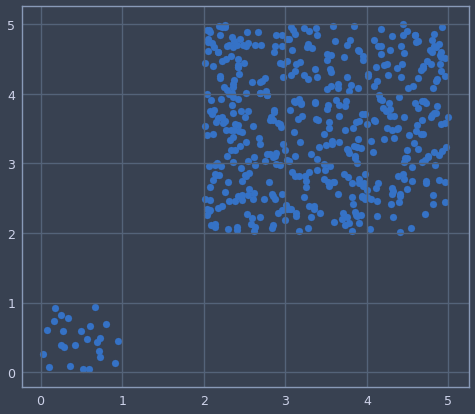

In [3]:
def make_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = rng.uniform(low=2, high=5, size=(int(n_samples * (1 - contamination)), 2))
    X_outliers = rng.uniform(low=0, high=1, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_dataset(500)
plt.scatter(X[:, 0], X[:, 1], color='b');

- The following function qp allows to solve a quadratic problem of the form:

$$
\left\{
  \begin{array}{cll}
  &\min_{(x)} \frac{1}{2}x^{\top} P x + q^\top x
  \\
   & \textrm{s.t.}\; A x = b, 0 \leq x \leq C.
  \end{array}
  \right.
$$

See documentation: http://cvxopt.org/userguide/coneprog.html#quadratic-programming

In [4]:
import cvxopt


def qp(P, q, A, b, C, verbose=True):
    # Gram matrix
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    A = cvxopt.matrix(A)
    b = cvxopt.matrix(b)
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                      np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(P, q, G, h, A, b, solver='mosec')
    return np.ravel(solution['x'])

Definition of the linear kernel:

In [5]:
def kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.dot(X1[i], X2[j])
    return K

**Remark:** You can use `sklearn.metrics.pairwise_distances` to avoid the for loops and make it faster.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Modify the following cell to solve the One-Class SVM dual problem.</li>
    </ul>
</div>

In [6]:
def ocsvm_solver(K, nu=0.1):
    n = K.shape[0]
    P = K
    q = np.zeros(n)
    A = np.ones((1,n))
    b = np.ones(1)
    C = 1/(nu*n)
    mu = qp(P, q, A, b, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = kernel(X, X)
# Uncomment the following lines when your ocsvm_solver is completed:
mu_support, idx_support = ocsvm_solver(K)
print(" Number of support vectors: %s" % idx_support.size)

 Number of support vectors: 50


<div class="alert alert-success">
    <b>QUESTION 5:</b>
     <ul>
      <li>Compute w using mu.</li>
    </ul>
</div>

In [7]:
w = X[idx_support].T.dot(mu_support)
print (w)

[ 1.37631398  1.37252753]


<div class="alert alert-success">
    <b>QUESTION 6:</b>
     <ul>
      <li>Using complementary slackness, explain how to obtain $\rho$ from $\mu$.</li>
    </ul>
</div>

**HINT:** Use the fact that for all support vectors for which $0 < \mu_i < \frac{1}{\nu n}$ one has $w^{t}x_{i} = \rho$.

The Karush-Khun and Tucker conditions for our dual problem gives us that at the optimum: 
$$\forall i \in [1,n]  \quad(\mu_i - \frac{1}{\nu n}  )(\langle w,x_i \rangle - \rho)\mu_i = 0 $$ 

Thus if $\mu_i \neq 0 $ and $\mu_i \neq \frac{1}{\nu n} $ then $ \rho  = \langle w,x_i \rangle  $

Moreover we saw that at the optimum $w = G^T \mu $
Thus $\boxed{\rho = \mu^T G x_i }$ 

In [8]:
def compute_rho(K, mu_support, idx_support):
    #Compute an index where mu is between 0 and 1/(nu*n)
    #We just retrieve the minimum value of mu_support
    ind = np.argmin(mu_support)
    return mu_support.T.dot( K[idx_support][:,idx_support][ind])

rho = compute_rho(K, mu_support, idx_support)

<div class="alert alert-success">
    <b>QUESTION 7:</b>
     <ul>
      <li>Verify that you find the same values as what scikit-learn gives. You should have the same support vectors and:


`rho = -ocsvm.intercept_[0] / (ocsvm.nu * len(K))`

and `mu_support = ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K))`</li>
    </ul>
</div>

In [9]:
from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from sklearn.svm import OneClassSVM

X = make_dataset(150)

ocsvm = OneClassSVM(kernel='linear', nu=0.05)
ocsvm.fit(X)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=ocsvm.nu)
rho = compute_rho(K, mu_support, idx_support)

# Check indices of support vectors
print(ocsvm.support_)
print(idx_support)

# Check rho
print(rho)
print(-ocsvm.intercept_[0] / (ocsvm.nu * len(K)))

# Check dual variables
print(mu_support)
print(ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

# Run formal tests:
assert_array_almost_equal(ocsvm.support_, idx_support)
assert_almost_equal(rho, -ocsvm.intercept_[0] / (ocsvm.nu * len(K)))
assert_array_almost_equal(mu_support, ocsvm.dual_coef_.ravel() / (ocsvm.nu * len(K)))

[  4  23  66  72  90  92 109 113]
[  4  23  66  72  90  92 109 113]
2.16400352023
2.16400355501
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]
[ 0.13422819  0.13422819  0.06040268  0.13422819  0.13422819  0.13422819
  0.13422819  0.13422819]


Check your code by running the following cell:

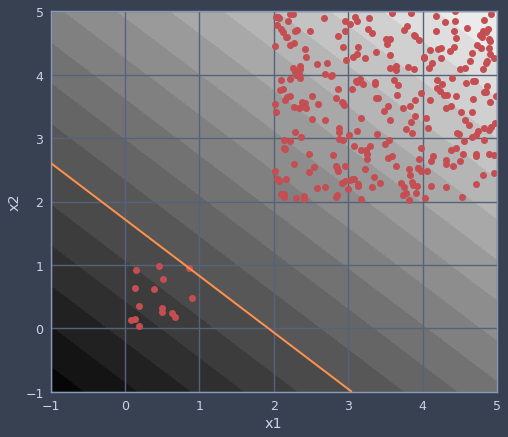

In [10]:
X = make_dataset(300)

K = kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.05)
rho = compute_rho(K, mu_support, idx_support)

def plot_ocsvm(X, mu_support, idx_support, rho, kernel=kernel):
    # Compute decision function on a grid
    X1, X2 = np.mgrid[-1:5.1:0.2, -1:5.1:0.2]
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    # Compute dot products
    X_support = X[idx_support]
    G = kernel(X_test, X_support)
    # Compute decision function

    decision = G.dot(mu_support) - rho

    # Compute predict label
    y_pred = np.sign(decision)

    # Plot decision boundary
    plt.plot(X[:,0], X[:, 1], 'or', linewidth=2)
    Z = np.reshape(decision, (na, nb))
    plt.contourf(X1, X2, Z, 20, cmap=plt.cm.gray)
    cs = plt.contour(X1, X2, Z, [0], colors='y', linewidths=2, zorder=10)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim([-1, 5])
    plt.ylim([-1, 5])

plot_ocsvm(X, mu_support, idx_support, rho)

<div class="alert alert-success">
    <b>QUESTION 8:</b>
     <ul>
      <li>Without any implementation, can you justify if you can apply any of the algorithm, among proximal gradient, coordinate descent, stochastic gradient descent and L-BFGS to the dual problem?
      </li>
    </ul>
</div>

Let us first notice that the dual can be rewritten:
$$\min_{\mu \in \mathbb{R}^n} \quad \frac{1}{2}\mu^{\top}GG^{t}\mu + \mathbb{1}_A(\mu) + \mathbb{1}_B(\mu)$$
Where $ A = \{x \in \mathbb{R}^n, x^T 1_n = 1 \} $
And $ B = \{ x \in \mathbb{R}^n, 0 \leq x \leq \frac{1}{\nu n } \} $
A and B are both convex sets.

* Proximal gradient: It can be applied, our problem is a sum of a convex differentiable and a convex non-differentiable fonction 

* Coordinate descent: We can apply the proximal version of the coordinate descent as shown in the lectures 

* Stochastic gradient descent: It can be applied to solve the primal but not to solve the dual.

* L-BFGS: We cannot apply L-BFGS to the dual

## Part 1: non-linear case with kernels

Another scenario is when the boundary between normal samples and outliers is not linear.

To cope with this the idea is to use kernels.

<div class="alert alert-success">
    <b>QUESTION 9:</b>
     <ul>
      <li>Denoting by $K(x_i, x_j)$ the dot product between samples show that dual problem and the decision function f(x) can be reformulated just using calls to $K$
      </li>
    </ul>
</div>

Let us call $K$ The matrix such that $K_{i,j} = K(x_i,x_j)$.

We have $G G^T = K $ Thus the dual can be rewritten: 

$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}K\mu
 \\
 \mathrm{s.t.}& \mu^{\top}1_n = 1
 \\
 \mathrm{and}& 0 \leq \mu \leq \frac{1}{\nu n}
 \end{array}
 \right .
$$

And the decision function: 
 $$
        y = \mathrm{sign}(\sum_{i=1}^{n} \mu_i K(x_i,x) - \rho) \enspace .
        $$

We will use another dataset to evaluate this:

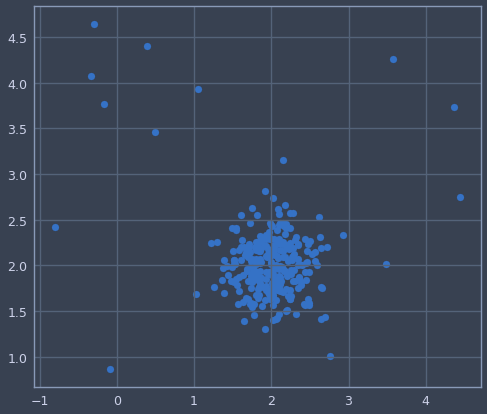

In [11]:
def make_blob_dataset(n_samples, contamination=0.05, random_state=42):
    rng = np.random.RandomState(random_state)
    X_inliers = 0.3 * rng.normal(size=(int(n_samples * (1. - contamination)), 2)) + 2
    X_outliers = rng.uniform(low=-1, high=5, size=(int(n_samples * contamination), 2))
    X = np.concatenate((X_inliers, X_outliers), axis=0)
    rng.shuffle(X)
    return X

X = make_blob_dataset(300)
plt.scatter(X[:, 0], X[:, 1], color='b');

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Update your kernel function so it computes the Gaussian kernel:
      
        $$
            K(x_i, x_j) = \exp(-\gamma \| x_i - x_j \|^2)
        $$

        where $\gamma > 0$ is the kernel bandwidth.
      </li>
    </ul>
</div>

In [12]:
from scipy import linalg
def rbf_kernel(X1, X2):
    n1 = X1.shape[0]
    n2 = X2.shape[0]
    K = np.empty((n1, n2))
    gamma = .3
    for i in range(n1):
        for j in range(n2):
            K[i, j] = np.exp(- gamma * np.linalg.norm(X1[i] - X2[j],2))
    return K

Using the change above the follwing code should allow you to nicely separate the dense region from the outliers

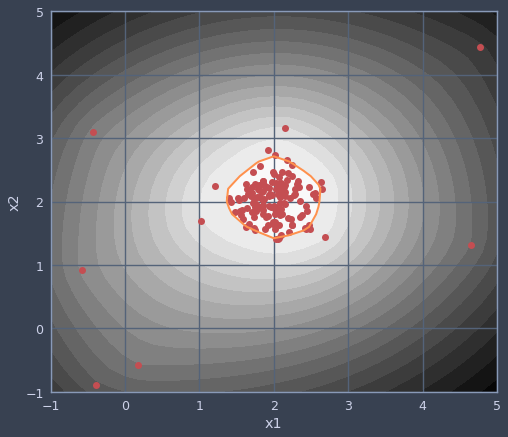

In [124]:
X = make_blob_dataset(150)

K = rbf_kernel(X, X)
mu_support, idx_support = ocsvm_solver(K, nu=0.1)
rho = compute_rho(K, mu_support, idx_support)
plot_ocsvm(X, mu_support, idx_support, rho, kernel=rbf_kernel)

## Part 2: One-class SVM without $\rho$

Formulation for example used in:

```
Consistency of one-class SVM and related algorithms
Régis Vert and Jean-philippe Vert
NIPS 2006
```

The problem of the formuation of SVMs with the variable $\rho$ is that
it leads to an annoying constraint in the dual, namely the $\mu^{\top}1_n = 1$.

We will now see what we can do about it.

Let's consider the problem

$$
	\begin{aligned}
	\min_{w, \xi} & \quad \frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n \xi_i \\
	\text{s.t.} & \quad \langle w, x_i \rangle \geq 1 - \xi_i \quad 1 \leq i \leq n \\
	& \quad \xi_i \geq 0 \quad 1 \leq i \leq n
	\end{aligned}
$$

<div class="alert alert-success">
    <b>QUESTION 10:</b>
     <ul>
      <li>Show that a dual problem of this problem is given by:
      
        $$
        (\mathcal{D}):
            \left\{
            \begin{array}{lll}
            \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{\top}\mu-\mu^{\top} 1_n
            \\
            \mathrm{s.t.}& 0 \leq \mu \leq \frac{C}{n}
            \end{array}
            \right .
        $$
      </li>
    </ul>
</div>

First we can, by the exact same reasoning than in question 2, rewrite the problem getting rid of the slack variable 
$$\min_w \frac{1}{2} \| w \|^2 + \frac{C}{n} \sum_{i=1}^n max(0,1- \langle w,x_i \rangle)$$

The problem can be rewritten in two sub-problems (we just need to find the better solution between both): 
$$ (\mathcal{P_1})\left\{
    \begin{array}{ll}
    \min_{w} &\frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n (1 - \langle w, x_i \rangle) \, 
    \\
    \langle w,x_i \rangle - 1 \leq 0 
    \end{array}
    \right.
    $$
And 
$$(\mathcal{P_2})\left\{
    \begin{array}{ll}
    \min_{w,\rho} \frac{1}{2}\Vert w \Vert^2  
    \\
    1 - \langle w,x_i \rangle   \leq 0 
    \end{array}
    \right.
    $$
    

Let us consider the problem $(\mathcal{P_1})$: 

For this problem we can write the Lagrangian, let us define : $\lambda \in \mathbb{R}^n_+$ 
$$\mathcal{L}(w,\lambda) = \frac{1}{2}\Vert w \Vert^2 + \frac{C}{n} \sum_{i=1}^n (1 - \langle w, x_i \rangle) + \sum_{i=1}^n \lambda_i (\langle w,x_i \rangle - 1)$$


Let us call $w^*$ the optimum, we have: 
  $$\frac{\partial \mathcal{L}}{w}(w^*, \rho,\lambda) = 0 $$
  Thus 
  $$w^* + \sum_{i=1}^n ( - \frac{C}{ n } + \lambda_i ) x_i = 0 $$
  And 
  $$ \boxed{w^* = \sum_{i=1}^n (\frac{C}{n } -  \lambda_i ) x_i}$$
     
   Let us define $$\mu = \frac{C 1_n}{n} - \lambda$$ 
   Then, 
   $$\boxed{w^* = \sum_{i=1}^n \mu_i  x_i = G^T\mu}$$
   Where $G = \begin{bmatrix}x_{1}^{\top} \\ \vdots \\ x_{n}^{\top}\end{bmatrix} $
   
   Thus :
  
   $$\mathcal{L}(w^*,\mu)  = \frac{1}{2} \mu^T G G^T \mu + \mu^T 1_n - \mu^T G G^T \mu $$
  
   $$\boxed{\mathcal{L}(w^*,\mu)  = -\frac{1}{2} \mu^T G G^T \mu  + \mu^T 1_n} $$
   Moreover $ \lambda \in \mathcal{R}^n_+ \implies  \mu \leq \frac{C}{n}$
   
   Thus, the dual problem associated with problem $ (\mathcal{P_1})$ is (maximizing an negative is the same as minimizing a positive) :
   $$
(\mathcal{D_1}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu - \mu^T 1_n
 \\
 \mathrm{s.t.}& \mu \leq \frac{C}{n}
 \end{array}
 \right .
$$

Let us now consider the problem $\mathcal{P_2}$ 
The lagrangian is: 
$$\mathcal{L}(w,\mu) = \frac{1}{2}\Vert w \Vert^2 + \sum_{i=1}^n \mu_i (1 -\langle w,x_i \rangle )$$
With $ \mu \in \mathbb{R}^n_+ $ 
Using the same notation as above we have: 
  $$\frac{\partial \mathcal{L}}{w}(w^*, \rho,\mu ) = 0 \implies w^* = G^T \mu  $$

Thus by the same computation than above, the dual problem associated with problem $(\mathcal{P_2})$ is: 
   $$
(\mathcal{D_2}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu - \mu^T 1_n 
 \\
 \mathrm{s.t.}&0 \leq \mu 
 \end{array}
 \right .
$$

Putting the two results together we get the full dual problem: 
$$
(\mathcal{D}): 
 \left\{
 \begin{array}{lll}
 \min_{\mu} &\frac{1}{2}\mu^{\top}GG^{t}\mu - \mu^T 1_n 
 \\
 \mathrm{s.t.}&  0 \leq \mu \leq \frac{C}{n}
 \end{array}
 \right .
$$

<div class="alert alert-success">
    <b>QUESTION 11:</b>
     <ul>
      <li> Rewrite the dual in the form:
      
            $$
            (\mathcal{D}): \min_{\mu} f(\mu) + g(\mu) .
            $$

            where $f$ is here a smooth function of $\mu$ with L-Liptschitz gradient and $g$ is a non-smooth function that is separable, namely:

            $$
            g(\mu) = \sum_{i=1}^n g_i(\mu_i)
            $$
      </li>
    </ul>
</div>



Let us define: 
$$f(\mu) = \frac{1}{2}\mu^{\top}GG^{t}\mu - \mu^T 1_n $$,f is twice differentiable thus smooth
$$\forall i \in [1,n] g_i(\mu) = \mathbb{1}_{0 \leq  \mu_i \leq \frac{C}{n} }(\mu) $$
Then we can write the dual: 
 $$(\mathcal{D}): \min_{\mu} f(\mu) + g(\mu)$$ .

The dual in the later form can be readily optimized using the methods that you have been studying in this class:

- Proximal gradient method with and without acceleration
- L-BFGS-B
- Coordinate descent

<div class="alert alert-success">
    <b>QUESTION 12:</b>
    Implement:
     <ul>
      <li> your own solver based on the QP function in cvxopt (reuse `qp` function above).</li>
      <li> your own solver of proximal gradient with and without acceleration</li>
      <li> your own version of coordinate descent</li>
      <li> an L-BFGS-B solver using `scipy.optimize.fmin_l_bfgs_b`</li>
    </ul>
</div>

You will test your implementations on the Gaussian blob corrupted with some uniform noise obtained with `make_blob_dataset` function.

You will make sure that all solvers converge towards the same minimum !

You will evaluate the performance of your implementations in terms of computation time on problems where the matrix $G G^\top$ can fit in memory on your machine.

You should reuse as much as possible the convergence evaluation code that you used during the labs.

**Remark:** For the coordinate descent method there exist some smart updates provided you use a linear kernel.

**BONUS (Hard):** Explain without implementing it how such smart updates could work for the coordinate descent solver.

**IMPORTANT : This question 12 is the most important and will constitute half of the final grade on the project !**

In [14]:
#Inspector to evaluate the solvers 
import time


def inspector(loss_fun, x_real, n_iter,verbose=False):
    """A closure called to update metrics after each iteration."""
    objectives = []
    errors = []
    t0 = time.time()
    it = [0]  # This is a hack to be able to modify 'it' inside the closure.
    timing = []

    def inspector_cl(xk):
        obj = loss_fun(xk) - loss_fun(x_real)
        err = np.linalg.norm(xk - x_real)
        tim = time.time() - t0
        objectives.append(obj)
        errors.append(err)
        timing.append(tim)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8)
                                  for name in ["it", "obj", "err", "time"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(
                    8), ("%.2e" % err).rjust(8), ("%.4e" % tim).rjust(8)]))
            it[0] += 1
    inspector_cl.obj = objectives
    inspector_cl.err = errors
    inspector_cl.timing = timing

    return inspector_cl

In [118]:
class OCSVM(object):
    """A class for the One Class SVM problem."""

    def __init__(self, K, C):
        self.K = K
        self.n = K.shape[0]
        self.C = float(C)

    def grad(self, mu):
        """Returns the gradient of the loss function."""
        return self.K.dot(mu) - 1

    def loss(self, mu):
        """Returns the loss function"""
        return mu.T.dot(K).dot(mu) - np.sum(mu) + self.indicator(mu)

    def indicator(self, mu):
        """Returns 0 if mu is between 0 and C/n else infinity."""
        if (np.any(mu < 0) or np.any(mu > self.C / self.n)):
            return np.inf
        else:
            return 0

    def grad_i(self, i, mu):
        """Return the ith coordinate of the gradient"""
        return K[i,:].dot(mu) - 1  

    def prox_g(self, mu):
        """Projection on [0,C/n]."""
        return np.minimum(np.maximum(mu, 0), self.C / self.n)

    def lipschitz_constant(self):
        """Return the Lipschitz constant of the gradient"""
        return np.linalg.norm(K, 2)**2

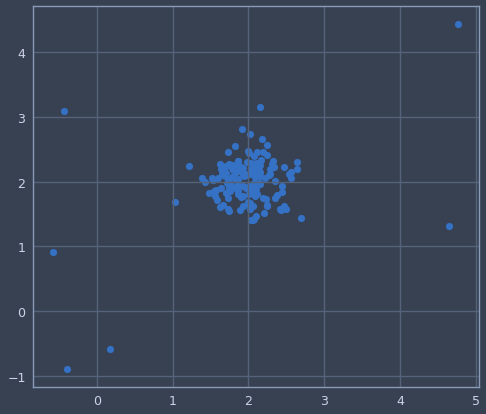

In [125]:
#Make the dataset 
X = make_blob_dataset(150)
plt.scatter(X[:, 0], X[:, 1], color='b');
K = rbf_kernel(X,X)
model = OCSVM(K,10)
n_iter = 100

In [138]:
from scipy.optimize import fmin_l_bfgs_b
x_init = np.zeros(model.n)
bounds = [(0,model.C/model.n) for _ in range(model.n)]
mu_true, f_min, _ = fmin_l_bfgs_b(
    model.loss, x_init, model.grad, bounds = bounds,pgtol=1e-30, factr=1e-30)
print(mu_true)

[ 0.00457545  0.00479386  0.00440045  0.00434933  0.00470633  0.00464023
  0.00458379  0.00424063  0.0047859   0.00438114  0.00444363  0.00433308
  0.00448997  0.00461715  0.00467928  0.00475857  0.00429542  0.00427761
  0.00428349  0.00461581  0.0042878   0.00474513  0.00429969  0.00452216
  0.0044944   0.00441878  0.00430316  0.00430356  0.00460605  0.00425766
  0.00457032  0.00459911  0.00447595  0.00424197  0.00455033  0.00490753
  0.00433984  0.00446537  0.00431863  0.00432557  0.00423933  0.004299
  0.00430923  0.00429388  0.00463472  0.00459132  0.00435287  0.00441961
  0.00440733  0.00425176  0.00428595  0.00449435  0.00471493  0.00757484
  0.00431135  0.00427904  0.00447094  0.00426177  0.00424488  0.00430368
  0.00428852  0.00457869  0.00466483  0.00443562  0.00509259  0.00787467
  0.0043262   0.00429915  0.00454798  0.0043302   0.00424201  0.00443962
  0.00753911  0.00479092  0.00482926  0.00437584  0.0047651   0.00498672
  0.00439987  0.00468297  0.00424335  0.00527289  0.0

### QP solver 

In [127]:
def qp_rholess(P, q, C, verbose=True):
    # Gram matrix
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                     np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

    # Solve QP problem
    cvxopt.solvers.options['show_progress'] = verbose
    solution = cvxopt.solvers.qp(P, q, G, h, solver='mosec')
    return np.ravel(solution['x'])

/home/aymon/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


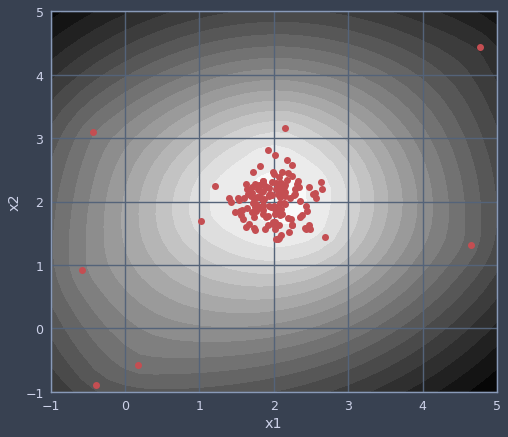

In [151]:
def ocsvm_solver_rholess(model,callback = None):
    n = model.n
    P = model.K
    q = -np.ones(n)
    C = model.C/n
    mu = qp_rholess(P, q, C, verbose=False)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

K = rbf_kernel(X, X)
#Compute the true minmum 
mu_support_true, idx_support_true = ocsvm_solver_rholess(model)
mu_true = np.zeros(model.n)
mu_true[idx_support_true] = mu_support_true
plot_ocsvm(X, mu_support, idx_support,rho=1, kernel=rbf_kernel)

### Proximal ISTA solver

In [139]:
def prox_ista(mu_init, model, n_iter=100, step=1., callback=None):
    """ISTA algorithm."""
    mu = mu_init.copy()

    for _ in range(n_iter): 
        mu = model.prox_g(mu - step * model.grad(mu))
        # Update metrics after each iteration.
        if callback is not None:
            callback(mu)

    return mu

   it    |   obj    |   err    |   time  
       0 | 2.96e-01 | 4.27e-02 | 2.7249e-03
      20 | 1.20e-01 | 1.60e-01 | 5.5487e-03
      40 | 1.19e-01 | 1.81e-01 | 8.4496e-03
      60 | 1.22e-01 | 1.98e-01 | 1.1388e-02
      80 | 1.24e-01 | 2.11e-01 | 1.4316e-02


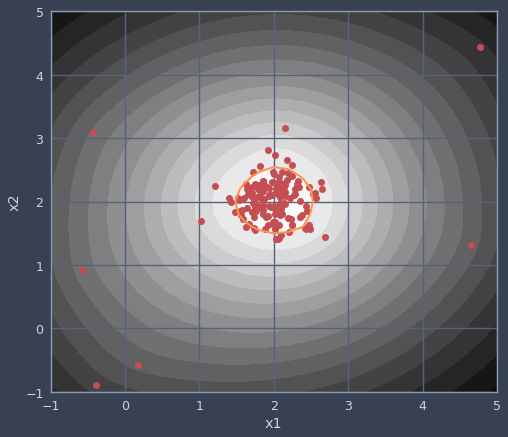

In [150]:
prox_ista_inspector = inspector(model.loss,mu_true,n_iter=n_iter,verbose=True)
mu = prox_ista(np.zeros(model.n),model,n_iter=n_iter,step=1./model.lipschitz_constant(),callback=prox_ista_inspector)
plot_ocsvm(X, mu, range(len(mu)),rho=1, kernel=rbf_kernel)

### Proximal FISTA solver

In [141]:
def prox_fista(mu_init, model, n_iter=100, step=1., callback=None):
    """FISTA algorithm."""
    mu = x_init.copy()
    y = x_init.copy()
    t = 1.

    for _ in range(n_iter):
        mu_new = model.prox_g((y - step * model.grad(y)))
        t_new = (1. + np.sqrt(1 + 4 * t**2)) / 2.
        y = mu_new + (t - 1.) / t_new * (mu_new - mu)
        mu = mu_new
        t = t_new

        # Update metrics after each iteration.
        if callback is not None:
            callback(mu)
    return mu

   it    |   obj    |   err    |   time  
       0 | 2.96e-01 | 4.27e-02 | 2.1255e-03
      20 | 1.30e-01 | 2.08e-01 | 5.2156e-03
      40 | 1.34e-01 | 2.48e-01 | 7.8678e-03
      60 | 1.32e-01 | 2.60e-01 | 1.0446e-02
      80 | 1.31e-01 | 2.69e-01 | 1.3001e-02


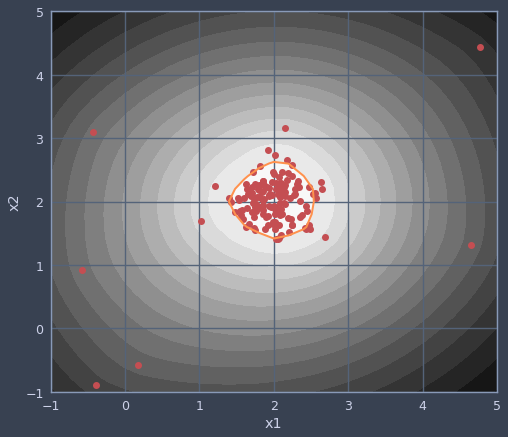

In [142]:
prox_fista_inspector = inspector(model.loss,mu_true,n_iter = n_iter, verbose=True)
mu = prox_fista(np.zeros(model.n), model, n_iter=n_iter, step=1/model.lipschitz_constant(),callback=prox_fista_inspector)
plot_ocsvm(X, mu, range(len(mu)),rho=1, kernel=rbf_kernel)

### Coordinate descent 

In [143]:
def prox_cd(mu_init, model, n_iter = 100,step = 1.,callback = None):
    """Coordinate Descent algorithm."""
    mu = mu_init.copy()
    for k in range(model.n * n_iter):
        i = k % model.n
        mu[i] = model.prox_g(mu[i] - step * model.grad_i(i,mu))
            
         # Update metrics after each iteration.
        if (k % model.n == 0) and (callback is not None):
            callback(mu)
    return mu

   it    |   obj    |   err    |   time  
       0 | 3.04e-01 | 5.72e-02 | 2.9604e-03
      20 | 1.25e-01 | 1.60e-01 | 3.8483e-02
      40 | 1.22e-01 | 1.79e-01 | 7.3162e-02
      60 | 1.24e-01 | 1.97e-01 | 1.1156e-01
      80 | 1.26e-01 | 2.09e-01 | 1.4552e-01


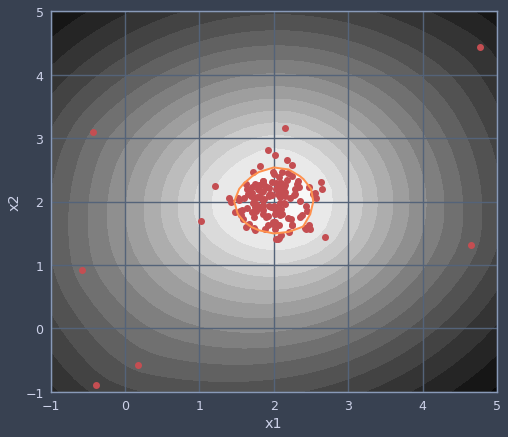

In [147]:
prox_cd_inspector = inspector(model.loss,mu_true,n_iter = n_iter, verbose=True)
mu = prox_cd(np.zeros(model.n),model,n_iter=n_iter,step=1./model.lipschitz_constant() , callback=prox_cd_inspector)
plot_ocsvm(X, mu, range(len(mu)),rho=1, kernel=rbf_kernel)

### F-BFGLS-B solver

   it    |   obj    |   err    |   time  
       0 | 8.02e-02 | 3.22e-02 | 9.2483e-04


/home/aymon/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


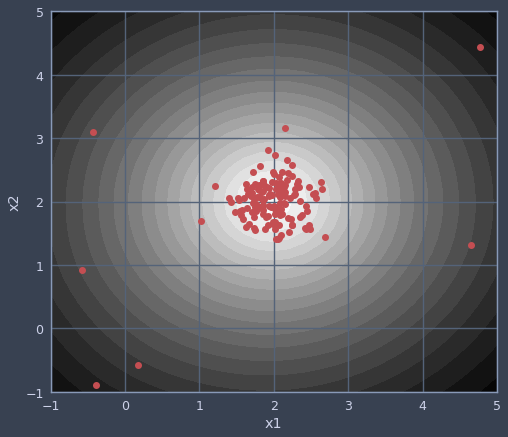

In [148]:
bounds = [(0,model.C/model.n) for _ in range(model.n)]
bfgls_inspector = inspector(model.loss,mu_true,n_iter = n_iter,verbose=True)
mu, _, _ = fmin_l_bfgs_b(
    model.loss, np.zeros(model.n) , model.grad, bounds = bounds,maxiter = n_iter,callback = bfgls_inspector)
plot_ocsvm(X, mu, range(len(mu)),rho=1, kernel=rbf_kernel)

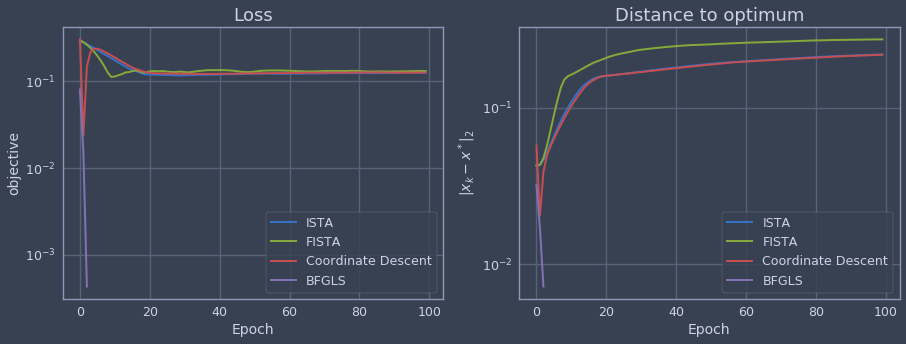

In [146]:
#Comparison 
plt.figure(figsize=(15, 5))

plt.subplot(1, 3,1)

inspectors = [prox_ista_inspector, prox_fista_inspector,prox_cd_inspector,bfgls_inspector]

solvers = ["ISTA", "FISTA","Coordinate Descent","BFGLS"]

for insp in inspectors:
    plt.semilogy(insp.obj, lw=2)
    plt.title("Loss", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("objective", fontsize=14)

plt.legend(solvers)

plt.subplot(1, 3, 2)

for insp in inspectors:
    plt.semilogy(insp.err, lw=2)
    plt.title("Distance to optimum", fontsize=18)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("$\|x_k - x^*\|_2$", fontsize=14)
    
plt.legend(solvers)

plt.subplot(1,3,3)
